# Galaxy Cluster Redshift Classification Using Machine Learning

Spring 2024 - PHYS 2550 - Final Project

*Jade Ducharme, Zacharias Escalante, Fei Fan, Soren Helhoski, Shi Yan*

This project aims to develop a machine learning model for classifying the redshifts of background
galaxies behind galaxy clusters using observational cosmology. By leveraging photometric proper-
ties of stars and galaxies, the project seeks to calculate new redshift values for each galaxy and
compare these with known spectroscopic redshift values to evaluate the model’s accuracy.

In [1]:
# import necessary packages
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns

# for aesthetics/plotting
sns.set_theme()
plt.style.use("seaborn-v0_8")

## Preprocessing

In [2]:
# Load data
from preprocess import load

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag")

print("Data shape [input_size, num_features]:\t", data.shape)
print("Label size [input_size,]:\t\t", labels.shape,"\n")
print("Feature names:", features)

Data shape [input_size, num_features]:	 (51295, 7)
Label size [input_size,]:		 (51295,) 

Feature names: ['res' 'u_cmodel_mag' 'g_cmodel_mag' 'r_cmodel_mag' 'i_cmodel_mag'
 'z_cmodel_mag' 'Y_cmodel_mag']


Let's visualize our inputs. First, we can plot the 1D histogram for any of our input features:

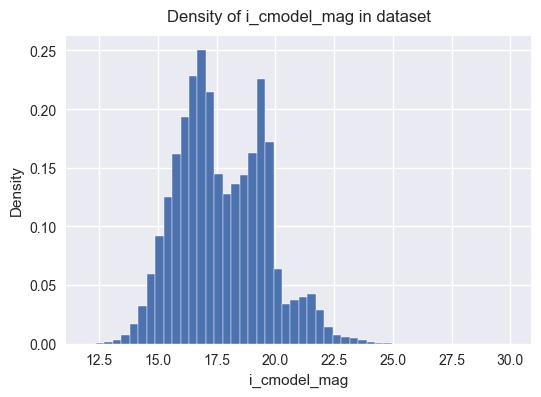

In [3]:
# Input visualization
from visualize import histogram_input

histogram_input(data, features, plot_feature="i_cmodel_mag", nbins=50, xrange=(12,30))

    

Next, we can also view how our labels align with any of the features in a 2D plot:

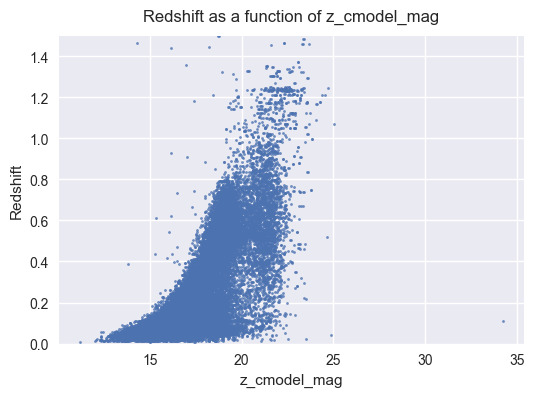

In [4]:
from visualize import plot_labels_features

plot_labels_features(data, labels, features, plot_feature="z_cmodel_mag", yrange=(0,1.5))

## Simple FCNN

As a first step, we would like to see how a simple FCNN performs.

In [5]:
from preprocess import preprocess_split
from model import SimpleFCNN, train_one_epoch, test

# model initialization
simple_fcnn = SimpleFCNN(num_features=len(features))
criterion = nn.MSELoss()
optimizer = optim.Adam(simple_fcnn.parameters(), lr=0.01)
acc_metric = torchmetrics.R2Score()  # TODO: maybe find a better accuracy metric?

# Device configuration
device = torch.device("mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu"))
print("Device:",device,"\n")
simple_fcnn.to(device)

# Data preparation
train_set, val_set, test_set = preprocess_split(data, labels, train_split=0.7, val_split=0.15)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=True)

loss_list, acc_list = [], []
val_loss_list, val_acc_list = [], []

num_epochs = 50
for e in range(1,num_epochs+1):

    # training
    loss, acc = train_one_epoch(simple_fcnn, device, train_loader, optimizer, criterion, acc_metric)
    loss_list.append(loss)
    acc_list.append(acc)

    # validation
    val_loss, val_acc = test(simple_fcnn, device, val_loader, criterion, acc_metric)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

    if e%5 == 0:
      print(f"Epoch {e:02d}\t Train loss: {loss:.4f}\t Train acc: {acc:.4f}\t"\
            + f"Val loss: {val_loss:.4f}\t Val acc: {val_acc:.4f}"
      )

Device: mps 

Epoch 05	 Train loss: 0.0694	 Train acc: -3.0520	Val loss: 0.0541	 Val acc: -3.0271
Epoch 10	 Train loss: 0.0524	 Train acc: -2.8672	Val loss: 0.0420	 Val acc: -2.8533
Epoch 15	 Train loss: 0.0537	 Train acc: -2.8981	Val loss: 0.0435	 Val acc: -2.8851
Epoch 20	 Train loss: 0.0772	 Train acc: -2.9153	Val loss: 0.0465	 Val acc: -2.9074
Epoch 25	 Train loss: 0.0511	 Train acc: -2.9004	Val loss: 0.0394	 Val acc: -2.9007
Epoch 30	 Train loss: 0.0542	 Train acc: -2.9074	Val loss: 0.0381	 Val acc: -2.9026
Epoch 35	 Train loss: 0.0574	 Train acc: -3.0094	Val loss: 0.0410	 Val acc: -3.0134
Epoch 40	 Train loss: 0.0571	 Train acc: -3.0105	Val loss: 0.0354	 Val acc: -3.0144
Epoch 45	 Train loss: 0.0513	 Train acc: -3.0086	Val loss: 0.0409	 Val acc: -3.0055
Epoch 50	 Train loss: 0.0548	 Train acc: -3.0164	Val loss: 0.0611	 Val acc: -3.0088


In [6]:
# How does the model perform on unseen data?

test_loss, test_acc = test(simple_fcnn, device, test_loader, criterion, acc_metric)

print(f"Final test loss: {test_loss:.4f}\t Final test acc: {test_acc:.4f}"
        )

Final test loss: 0.0627	 Final test acc: -2.9998


Next, we would like to visualize how our training went!

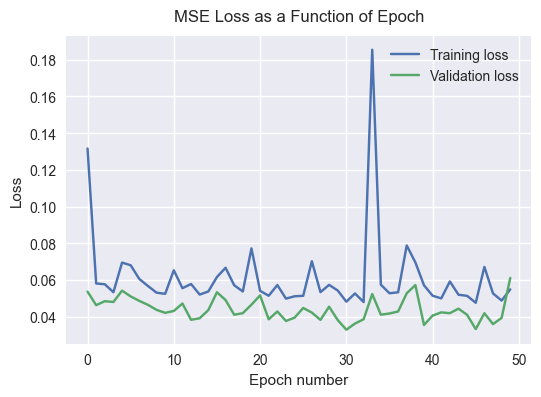

In [7]:
from visualize import plot_loss, plot_accuracy

plot_loss(loss_list, val_loss_list)

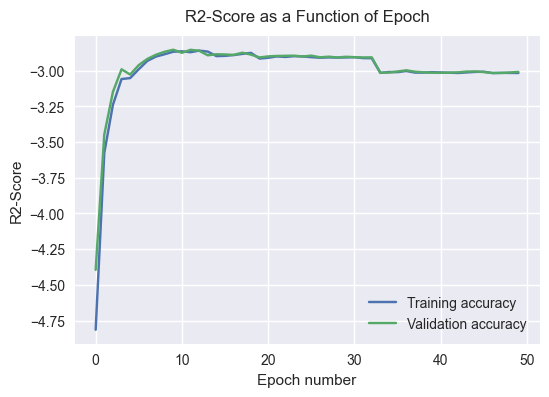

In [8]:
plot_accuracy(acc_list, val_acc_list)

Next, we would like to visualize the results of the model. In other words, given our set of test inputs, what kinds of outputs does our model predict?

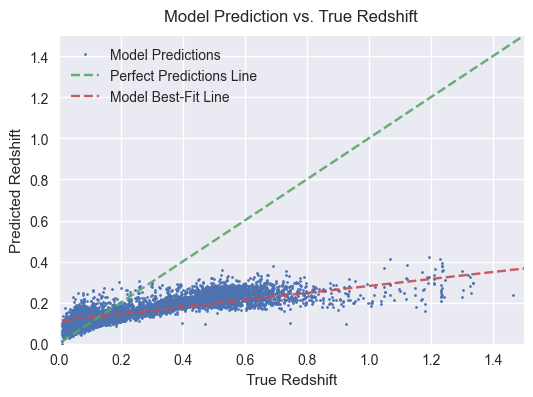

In [9]:
from visualize import visualize_predictions

visualize_predictions(test_set, simple_fcnn, device=device, xrange=(0,1.5), yrange=(0,1.5))

## 1D CNN

In [10]:
#TODO!

## K-Nearest Neighbors Regression

In [13]:
# Information about data

data, labels, features = load("./data/clean_specz_fluxes.csv", mode="mag") #Load in data

# print("Data shape [input_size, num_features]:\t", data.shape) #Get data attributes
# print("Label size [input_size,]:\t\t", labels.shape,"\n")
# print("Feature names:", features)
# print(data)

Test mse minmax: 0.018601704208695516
Optimal k minmax: 51
Test mse standard: 0.024193142558634004
Optimal k standard: 31
Test mse robust: 0.025473521478679387
Optimal k robust: 51


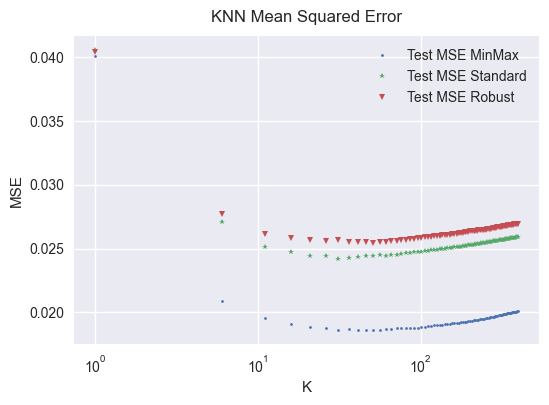

test mse mimax: 0.018601704208695516


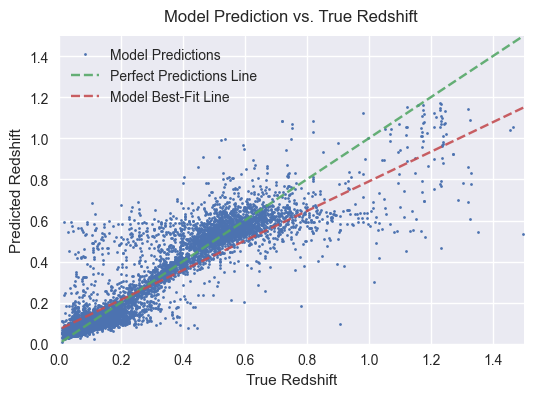

test mse standard: 0.024193142558634004


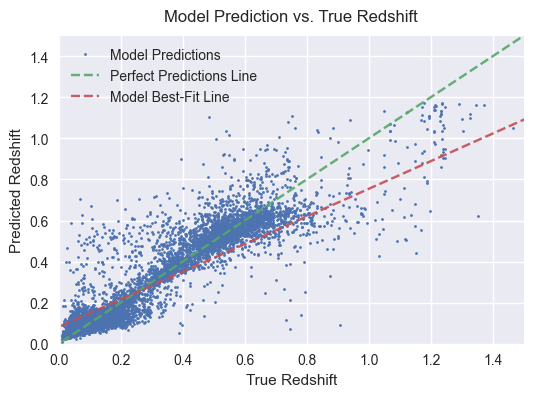

test mse robust: 0.025473521478679387


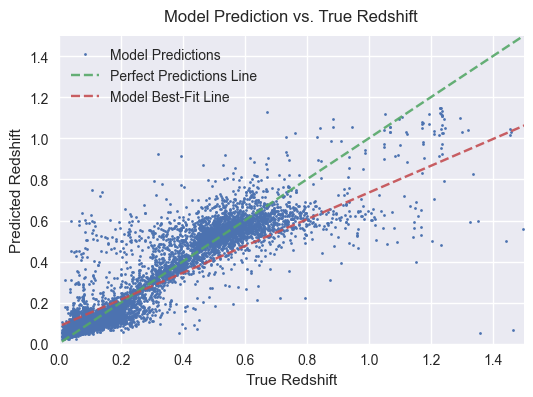

In [26]:
# Preprocessing 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from visualize import visualize_knn_predictions

minmax_scaler = MinMaxScaler() #Method of scaling feature values
standard_scaler = StandardScaler()
robust_scaler = RobustScaler()

    # test_mse.append(mean_squared_error(test_labels, y_pred))

data_rescaled_minmax = minmax_scaler.fit_transform(data) #Scale feature data to lie in (0,1)
data_rescaled_standard = standard_scaler.fit_transform(data)
data_rescaled_robust = robust_scaler.fit_transform(data)

X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax = train_test_split(data_rescaled_minmax, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)
X_train_standard, X_test_standard, y_train_standard, y_test_standard = train_test_split(data_rescaled_standard, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)
X_train_robust, X_test_robust, y_train_robust, y_test_robust = train_test_split(data_rescaled_robust, labels, test_size=0.2) #Shuffle and split data in training (20%) and testing (80%)

k_vals = range(1, 400, 5) #Range of k neighbors to try

# Training

def knn_regression(train_data, test_data, train_labels, test_labels, k):
    knn = KNeighborsRegressor(n_neighbors = val, weights = "distance") #Default weights are "uniform". "distance" weight points by the inverse of their distance.
    knn.fit(train_data, train_labels)

    y_pred = knn.predict(test_data)

    return mean_squared_error(test_labels, y_pred) #Returns mse

test_mse_minmax = []; test_mse_standard = []; test_mse_robust = [];


for val in k_vals:
    test_mse_minmax.append(knn_regression(X_train_minmax, X_test_minmax, y_train_minmax, y_test_minmax, k = val))
    test_mse_standard.append(knn_regression(X_train_standard, X_test_standard, y_train_standard, y_test_standard, k = val))
    test_mse_robust.append(knn_regression(X_train_robust, X_test_robust, y_train_robust, y_test_robust, k = val))

k_opt_minmax = k_vals[test_mse_minmax.index(min(test_mse_minmax))] 
k_opt_standard = k_vals[test_mse_standard.index(min(test_mse_standard))] 
k_opt_robust = k_vals[test_mse_robust.index(min(test_mse_robust))] 

print(f'Test mse minmax: {test_mse_minmax[test_mse_minmax.index(min(test_mse_minmax))]}')
print(f'Optimal k minmax: {k_opt_minmax}')

print(f'Test mse standard: {test_mse_standard[test_mse_standard.index(min(test_mse_standard))]}')
print(f'Optimal k standard: {k_opt_standard}')

print(f'Test mse robust: {test_mse_robust[test_mse_robust.index(min(test_mse_robust))]}')
print(f'Optimal k robust: {k_opt_robust}')

# KNN Visualization

plt.figure(figsize=(6,4))
plt.title("KNN Mean Squared Error", y=1.02)
plt.semilogx(k_vals, test_mse_minmax, linestyle="", marker=".", markersize=4, label="Test MSE MinMax")
plt.semilogx(k_vals, test_mse_standard, linestyle="", marker="*", markersize=4, label="Test MSE Standard")
plt.semilogx(k_vals, test_mse_robust, linestyle="", marker="v", markersize=4, label="Test MSE Robust")
plt.xlabel("K")
plt.ylabel("MSE")

# plt.xlim(xrange[0], xrange[1])
# plt.ylim(yrange[0], yrange[1])

plt.legend()
plt.show()

knn_opt_minmax = KNeighborsRegressor(n_neighbors = k_opt_minmax, weights = "distance")
knn_opt_minmax.fit(X_train_minmax, y_train_minmax)
y_opt_pred_minmax = knn_opt_minmax.predict(X_test_minmax)

knn_opt_standard = KNeighborsRegressor(n_neighbors = k_opt_standard, weights = "distance")
knn_opt_standard.fit(X_train_standard, y_train_standard)
y_opt_pred_standard = knn_opt_standard.predict(X_test_standard)

knn_opt_robust = KNeighborsRegressor(n_neighbors = k_opt_robust, weights = "distance")
knn_opt_robust.fit(X_train_robust, y_train_robust)
y_opt_pred_robust = knn_opt_robust.predict(X_test_robust)

print(f'test mse mimax: {mean_squared_error(y_test_minmax, y_opt_pred_minmax)}')
visualize_knn_predictions(y_test_minmax, y_opt_pred_minmax, device = device, xrange=(0,1.5), yrange=(0,1.5))
print(f'test mse standard: {mean_squared_error(y_test_standard, y_opt_pred_standard)}')
visualize_knn_predictions(y_test_standard, y_opt_pred_standard, device = device, xrange=(0,1.5), yrange=(0,1.5))
print(f'test mse robust: {mean_squared_error(y_test_robust, y_opt_pred_robust)}')
visualize_knn_predictions(y_test_robust, y_opt_pred_robust, device = device, xrange=(0,1.5), yrange=(0,1.5))